In [358]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [359]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark= False

In [360]:
m = 500                 # 5, 50, 100, 500, 2000

In [361]:
train_size = 2000           # 100, 500, 2000, 10000

In [362]:
desired_num = train_size + 1000

In [363]:
tr_i = 0
tr_j = train_size
tr_k = desired_num

tr_i, tr_j, tr_k

(0, 2000, 3000)

# Generate dataset

In [364]:
np.random.seed(12)
y = np.random.randint(0,3,500)
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

0 174
1 163
2 163


In [365]:
x = np.zeros((500,))

In [366]:
np.random.seed(12)
x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))

In [367]:
x[idx[0]][0], x[idx[2]][5] 

(-0.8458371576203276, 2.2459800877058114)

In [368]:
print(x.shape,y.shape)

(500,) (500,)


In [369]:
idx= []
for i in range(3):
  idx.append(y==i)

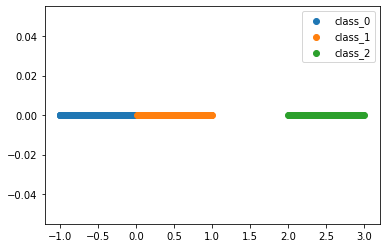

In [370]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [371]:
bg_idx = [ np.where(idx[2] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(163,)

In [372]:
np.unique(bg_idx).shape

(163,)

In [373]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [374]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([-1.00805526e-16]), array([-1.7163962]))

In [375]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [376]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([1.]), array([4.37808847]))

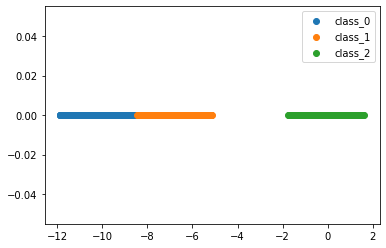

In [377]:
for i in range(3):
    y= np.zeros(x[idx[i]].shape[0])
    plt.scatter(x[idx[i]],y,label="class_"+str(i))
plt.legend()

In [378]:
foreground_classes = {'class_0','class_1' }

background_classes = {'class_2'}

In [379]:
fg_class  = np.random.randint(0,2)
fg_idx = np.random.randint(0,m)

a = []
for i in range(m):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(2,3)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 2 present at 0
background 2 present at 1
background 2 present at 2
background 2 present at 3
background 2 present at 4
background 2 present at 5
background 2 present at 6
background 2 present at 7
background 2 present at 8
background 2 present at 9
background 2 present at 10
background 2 present at 11
background 2 present at 12
background 2 present at 13
background 2 present at 14
background 2 present at 15
background 2 present at 16
background 2 present at 17
background 2 present at 18
background 2 present at 19
background 2 present at 20
background 2 present at 21
background 2 present at 22
background 2 present at 23
background 2 present at 24
background 2 present at 25
background 2 present at 26
background 2 present at 27
background 2 present at 28
background 2 present at 29
background 2 present at 30
background 2 present at 31
background 2 present at 32
background 2 present at 33
background 2 present at 34
background 2 present at 35
background 2 present at 36
background 

In [380]:
a.shape

(500,)

In [381]:
np.reshape(a,(m,1))

array([[-0.80241043],
       [ 1.00228507],
       [-0.81132988],
       [ 1.2774409 ],
       [ 0.57398646],
       [-0.91850331],
       [ 0.6600648 ],
       [ 0.57398646],
       [ 1.39799803],
       [ 0.13695373],
       [-1.44264034],
       [ 0.71837826],
       [ 1.08544127],
       [ 1.55171236],
       [ 0.4152144 ],
       [-1.15692643],
       [-1.62776348],
       [ 0.65339431],
       [ 0.44998336],
       [-1.35067387],
       [-0.1541663 ],
       [ 1.2774409 ],
       [ 0.44998336],
       [ 1.20061574],
       [-0.83952364],
       [ 0.46279645],
       [-0.90487837],
       [ 0.8325454 ],
       [-0.41161127],
       [-0.94524964],
       [-0.2407784 ],
       [ 0.80282356],
       [ 0.18678022],
       [ 0.41553291],
       [ 0.99304358],
       [-0.94524964],
       [-1.44264034],
       [-1.36429042],
       [-0.36474865],
       [ 0.1392267 ],
       [ 0.1428216 ],
       [-1.08085196],
       [ 0.6600648 ],
       [-1.17697967],
       [-0.29918788],
       [-1

In [382]:

mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,2)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [383]:
mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T
mosaic_list_of_images.shape

(3000, 500)

In [384]:
mosaic_list_of_images.shape, mosaic_list_of_images[0]

((3000, 500),
 array([ 1.43580093e+00,  1.36953727e-01, -4.25227595e-01, -9.18503310e-01,
        -1.29097509e-01, -1.73154424e+00,  7.55823134e-01,  6.64063803e-01,
        -1.54166304e-01,  8.32545402e-01,  1.31922113e+00, -4.11611269e-01,
         7.55823134e-01, -1.54166304e-01, -9.04878365e-01,  2.65519657e-01,
         1.41734616e+00, -1.35067387e+00, -9.18503310e-01, -8.48777450e-01,
         4.14971640e-01,  2.28435924e-01,  4.12048306e-01,  1.03957183e+00,
        -4.24738021e-01, -1.74493859e+00, -1.74493859e+00, -1.43069628e+00,
        -2.99187881e-01, -9.18503310e-01, -1.46523851e+00, -2.99187881e-01,
         7.18378258e-01, -1.37597620e+00,  6.53394308e-01,  3.45865811e-01,
         1.62014849e+00,  3.48205465e-01,  3.48205465e-01, -2.40778404e-01,
         7.81700467e-01, -5.29177237e-01,  1.39799803e+00,  2.28435924e-01,
        -1.20787928e+00,  1.04960385e+00, -1.15692643e+00, -1.07805031e+01,
        -1.54993781e+00, -9.92671849e-01,  1.00274723e+00, -1.57358463e+00

In [385]:
for j in range(m):
  print(mosaic_list_of_images[0][j])
  

1.4358009314866034
0.13695372724012772
-0.4252275951078302
-0.9185033095974854
-0.12909750858981067
-1.7315442430857817
0.7558231343879587
0.6640638025673503
-0.15416630449113
0.832545401567119
1.3192211298342615
-0.411611268813296
0.7558231343879587
-0.15416630449113
-0.9048783650832936
0.2655196567190298
1.4173461573148838
-1.3506738707130648
-0.9185033095974854
-0.8487774501542434
0.41497163990658553
0.22843592432187756
0.4120483059558463
1.039571830882509
-0.42473802055748705
-1.7449385946476759
-1.7449385946476759
-1.4306962812399096
-0.2991878808509575
-0.9185033095974854
-1.4652385079352608
-0.2991878808509575
0.7183782579402468
-1.3759761997330582
0.6533943080642937
0.345865811484694
1.6201484942286413
0.34820546484848275
0.34820546484848275
-0.24077840436878184
0.7817004669153338
-0.529177237043516
1.397998025695915
0.22843592432187756
-1.2078792839203505
1.0496038541198456
-1.1569264275370823
-10.780503085215361
-1.5499378105140722
-0.992671849313759
1.0027472329330642
-1.573

In [386]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number, m):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.zeros(m)
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([1], dtype=torch.float64)
    np.random.seed(int(dataset_number*10000 + i))
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(m):
      if j == give_pref:
        img = img + mosaic_dataset[i][j]*dataset_number/m   #2 is data dim
      else :
        img = img + mosaic_dataset[i][j]*(m-dataset_number)/((m-1)*m)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index
        
  

In [387]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr_j], mosaic_label[0:tr_j], fore_idx[0:tr_j] , 1, m)


test_dataset , labels , fg_index = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[tr_j : tr_k], mosaic_label[tr_j : tr_k], fore_idx[tr_j : tr_k] , m, m)

number of correct averaging happened for dataset 1 is 2000
the averaging are done as  [ 3.  4.  3.  2.  3.  5.  3.  6.  3.  1.  1.  3.  6.  4.  3.  3.  8.  4.
  6.  3.  1.  3.  7.  5.  4.  3.  3.  2.  6.  1.  7.  3.  3.  4.  6.  5.
  0.  3.  3.  5.  5.  4.  3.  1.  3.  2.  3.  5.  3.  4.  4.  7.  1.  3.
  5.  6.  5.  2.  6.  1.  3.  4.  4.  4.  2.  4. 10.  0.  3.  5.  8.  2.
  3.  7.  3.  1.  2.  6.  6.  3.  8.  3.  2.  6.  5.  3.  6.  5.  1.  3.
  4.  2.  5.  2.  5.  4.  1.  6.  3.  7.  3.  5.  6.  6.  4.  6.  6.  4.
  3.  4.  7.  5.  3.  3.  5.  3.  5.  8.  2.  5.  6.  5.  1.  2.  7.  6.
  3.  3.  8.  1.  3.  3.  3.  1.  4.  1.  3.  2.  1.  5.  2.  1.  2.  6.
  5.  6.  4.  6.  3.  3.  4.  6.  4.  6.  7.  3.  9.  3.  4.  5.  5.  3.
  3.  3.  2.  1.  5.  4.  5.  8.  4.  1.  3.  3.  5.  1.  7.  6.  7.  4.
  5.  3.  6.  5.  4.  7.  3.  6.  3. 12.  3.  2.  3.  7.  4.  3.  7.  3.
  6.  4.  3.  5.  4.  4.  7.  2.  4.  4.  3.  4.  4.  3.  6.  4.  5.  7.
  2.  3.  7.  3.  5.  2.  5.  7.  2.  

In [388]:
avg_image_dataset_1 = torch.stack(avg_image_dataset_1, axis = 0)

# mean = torch.mean(avg_image_dataset_1, keepdims= True, axis = 0)
# std = torch.std(avg_image_dataset_1, keepdims= True, axis = 0)

# avg_image_dataset_1 = (avg_image_dataset_1 - mean) / std 

# print(torch.mean(avg_image_dataset_1, keepdims= True, axis = 0))
# print(torch.std(avg_image_dataset_1, keepdims= True, axis = 0))
# print("=="*40)


test_dataset = torch.stack(test_dataset, axis = 0)
# mean = torch.mean(test_dataset, keepdims= True, axis = 0)
# std = torch.std(test_dataset, keepdims= True, axis = 0)
# test_dataset = (test_dataset - mean) / std

# print(torch.mean(test_dataset, keepdims= True, axis = 0))
# print(torch.std(test_dataset, keepdims= True, axis = 0))
# print("=="*40)


Text(0.5, 1.0, 'dataset1 CIN with alpha = 1/500')

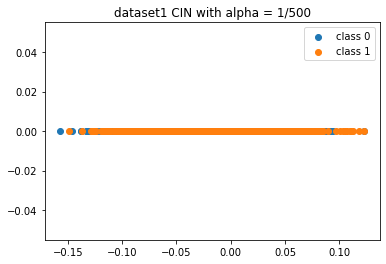

In [389]:
x1 = (avg_image_dataset_1).numpy()
y1 = np.array(labels_1)

# idx1 = []
# for i in range(3):
#   idx1.append(y1 == i)

# for i in range(3):
#     z = np.zeros(x1[idx1[i]].shape[0])
#     plt.scatter(x1[idx1[i]],z,label="class_"+str(i))
# plt.legend()

plt.scatter(x1[y1==0], y1[y1==0]*0, label='class 0')
plt.scatter(x1[y1==1], y1[y1==1]*0, label='class 1')
# plt.scatter(x1[y1==2], y1[y1==2]*0, label='class 2')
plt.legend()
plt.title("dataset1 CIN with alpha = 1/"+str(m))

Text(0.5, 0, 'X')

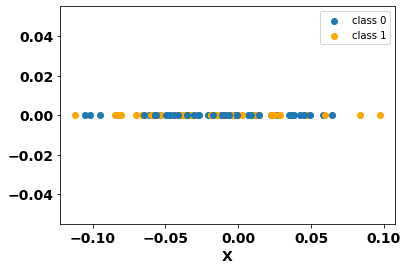

In [390]:
x1 = (avg_image_dataset_1).numpy()
y1 = np.array(labels_1)

idx_1 = y1==0
idx_2 = np.where(idx_1==True)[0]
idx_3 = np.where(idx_1==False)[0]
color = ['#1F77B4','orange', 'brown']

true_point = len(idx_2)
plt.scatter(x1[idx_2[:25]], y1[idx_2[:25]]*0, label='class 0', c= color[0], marker='o')
plt.scatter(x1[idx_3[:25]], y1[idx_3[:25]]*0, label='class 1', c= color[1], marker='o')

plt.scatter(x1[idx_3[50:75]], y1[idx_3[50:75]]*0,  c= color[1], marker='o')
plt.scatter(x1[idx_2[50:75]], y1[idx_2[50:75]]*0,  c= color[0], marker='o')


plt.legend()
plt.xticks( fontsize=14, fontweight = 'bold')
plt.yticks( fontsize=14, fontweight = 'bold')
plt.xlabel("X", fontsize=14, fontweight = 'bold')
# plt.savefig(fp_cin+"ds1_alpha_04.png", bbox_inches="tight")
# plt.savefig(fp_cin+"ds1_alpha_04.pdf", bbox_inches="tight")

In [391]:
avg_image_dataset_1[0:10]

tensor([[-0.0209],
        [-0.0137],
        [-0.0202],
        [-0.0834],
        [-0.0340],
        [ 0.0224],
        [-0.0028],
        [-0.0190],
        [-0.0808],
        [-0.0464]], dtype=torch.float64)

Text(0.5, 1.0, 'test dataset1 ')

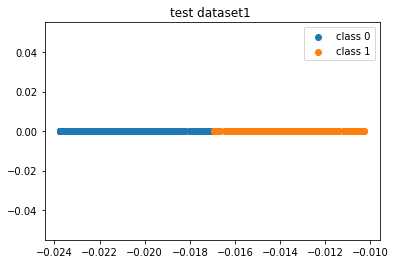

In [392]:
x1 = (test_dataset).numpy()/m
y1 = np.array(labels)

# idx1 = []
# for i in range(3):
#   idx1.append(y1 == i)

# for i in range(3):
#     z = np.zeros(x1[idx1[i]].shape[0])
#     plt.scatter(x1[idx1[i]],z,label="class_"+str(i))
# plt.legend()

plt.scatter(x1[y1==0], y1[y1==0]*0, label='class 0')
plt.scatter(x1[y1==1], y1[y1==1]*0, label='class 1')
# plt.scatter(x1[y1==2], y1[y1==2]*0, label='class 2')
plt.legend()
plt.title("test dataset1 ")

In [393]:
test_dataset.numpy()[0:10]/m

array([[-0.0233164 ],
       [-0.02181399],
       [-0.01038712],
       [-0.0210542 ],
       [-0.02166427],
       [-0.01090157],
       [-0.02117156],
       [-0.0135526 ],
       [-0.01197566],
       [-0.02285899]])

In [394]:
test_dataset = test_dataset/m

In [395]:
test_dataset.numpy()[0:10]

array([[-0.0233164 ],
       [-0.02181399],
       [-0.01038712],
       [-0.0210542 ],
       [-0.02166427],
       [-0.01090157],
       [-0.02117156],
       [-0.0135526 ],
       [-0.01197566],
       [-0.02285899]])

In [396]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [397]:
avg_image_dataset_1[0].shape, avg_image_dataset_1[0]

(torch.Size([1]), tensor([-0.0209], dtype=torch.float64))

In [398]:
batch = 200

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [399]:
testdata_1 = MosaicDataset(test_dataset, labels )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

In [400]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(1,50)
        self.linear2 = nn.Linear(50,2)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = (self.linear2(x))

        return x

In [401]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [402]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [403]:
def train_all(trainloader, ds_number, testloader_list, lr_list):
  
  final_loss = []
  for LR in lr_list:    
    print("--"*20, "Learning Rate used is", LR)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr = LR ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1500
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    final_loss.append(loss_curi) 
  return final_loss
    

In [404]:
train_loss_all=[]

testloader_list= [ testloader_1 ]
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5 ]

In [405]:
fin_loss = train_all(trainloader_1, 1, testloader_list, lr_list)
train_loss_all.append(fin_loss)

---------------------------------------- Learning Rate used is 0.0001
epoch: [0 ] loss: 0.694
epoch: [1] loss: 0.694
epoch: [201] loss: 0.691
epoch: [401] loss: 0.690
epoch: [601] loss: 0.690
epoch: [801] loss: 0.690
epoch: [1001] loss: 0.690
epoch: [1201] loss: 0.690
epoch: [1401] loss: 0.690
Finished Training
Accuracy of the network on the 2000 train images: 53.20 %
unique out:  [0 1] unique pred:  [0]
correct:  523 total  1000
Accuracy of the network on the 1000 test dataset 1: 52.30 %
--------------------------------------------------------------------------------
---------------------------------------- Learning Rate used is 0.0005
epoch: [0 ] loss: 0.694
epoch: [1] loss: 0.693
epoch: [201] loss: 0.690
epoch: [401] loss: 0.689
epoch: [601] loss: 0.689
epoch: [801] loss: 0.689
epoch: [1001] loss: 0.689
epoch: [1201] loss: 0.689
epoch: [1401] loss: 0.689
Finished Training
Accuracy of the network on the 2000 train images: 53.55 %
unique out:  [0 1] unique pred:  [0]
correct:  523 tot

In [406]:
%matplotlib inline

In [407]:
len(fin_loss)

8

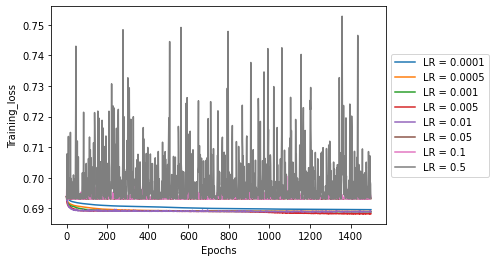

In [408]:
for i,j in enumerate(fin_loss):
    plt.plot(j,label ="LR = "+str(lr_list[i]))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))